<a id='top'></a>
# Modeling: Logistic Regression


<a href=#readdata>Read Data</a>  

<a href=#logreg>Logistic Regression</a>

<a href=#inspectfeatures>Inspect Features</a>

<a href=#dummy>One Hot Encode</a>

<a href=#balancedata>Balance Data</a>

<a href=#logistic_rebalance>Logistic Regression on Re-Balance Data</a>

<a href=#plot>Plot ROC Curve</a>

<a href=#bottom>Bottom</a>


In [1]:
# Ignore 'dask' warning

import pandas as pd
import gcsfs
from google.cloud import storage
from pandas import DataFrame
from IPython.display import HTML
from google.cloud.storage import Blob
import datalab.storage as gcs_datalab
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn import preprocessing

from matplotlib import pyplot
import seaborn as sns
from scipy import stats

# Read in data from bucket:

In [2]:
# Setting up constants. All required
project = 'graydon-moving-indicator'
bucket_name = 'graydon-data'

In [3]:
# Initializing bucket
fs = gcsfs.GCSFileSystem(project='graydon-moving-indicator')
gcs = storage.Client()
bucket = gcs.get_bucket(bucket_name)

In [5]:
# Read one year
one_year_df = read_one_year_from_bucket_merged_csv(dir_prefix= 'including_scores/merged_per_year/aggregated/', 
                                                   year = '2017')

Starting with year:  2017
including_scores/merged_per_year/aggregated/
blob including_scores/merged_per_year/aggregated/
The number of rows so far is:  0
blob including_scores/merged_per_year/aggregated/2017_merged_cleaned.csv
Processing file:  including_scores/merged_per_year/aggregated/2017_merged_cleaned.csv


ValueError: 'date_established' is not in list

<a id='readdata'></a>

# Read in data from CSV file

<a href=#top>Top</a>

In [2]:
data_df = pd.read_csv('../Data_Merging/subset_2018.csv')

In [3]:
data_df.columns

Index(['Unnamed: 0', 'date_month', 'id_company', 'id_branch',
       'is_discontinued', 'financial_calamity_outcome', 'qty_employees',
       'year_qty_employees', 'id_company_creditproxy',
       'score_payment_assessment', 'amt_revenue', 'year_revenue',
       'amt_consolidated_revenue', 'year_consolidated_revenue',
       'amt_consolidated_operating_result',
       'year_consolidated_operating_result', 'perc_credit_limit_adjustment',
       'color_credit_status', 'rat_pd', 'score_pd', 'has_increased_risk',
       'is_sole_proprietor', 'code_sbi_2', 'code_sbi_1',
       'qty_address_mutations_total', 'qty_address_mutations_month',
       'has_relocated', 'has_name_change', 'vice_president'],
      dtype='object')

In [4]:
data_df.has_relocated.value_counts()

False    1342874
True        5818
Name: has_relocated, dtype: int64

In [5]:
data_df.has_relocated.value_counts() / data_df.shape[0]

False    0.995686
True     0.004314
Name: has_relocated, dtype: float64

<a id='logreg'></a>
# Logistic Regression:

<a href=#top>Top</a>

In [41]:
feature_cols = ['score_pd', 'score_payment_assessment', 'code_sbi_2', 'color_credit_status']

In [68]:
data_to_model = data_df[feature_cols + ['has_relocated']]

In [79]:
data_to_model.head()

,score_pd,score_payment_assessment,code_sbi_2,has_relocated,color_credit_status_G,color_credit_status_O,color_credit_status_R
0,-4.851,28.0,47.0,False,0,0,1
1,-5.066,20.0,45.0,False,1,0,0
2,-5.658,28.0,55.0,False,1,0,0
3,-5.009,20.0,27.0,False,1,0,0
4,-5.657,20.0,94.0,False,1,0,0


In [89]:
features_in_model = data_to_model.columns.tolist()

In [94]:
features_in_model

['score_pd',
 'score_payment_assessment',
 'code_sbi_2',
 'has_relocated',
 'color_credit_status_G',
 'color_credit_status_O',
 'color_credit_status_R']

In [95]:
features_in_model.remove('has_relocated')

In [96]:
x_train, x_test, y_train, y_test = train_test_split(data_to_model[features_in_model], data_to_model.has_relocated, 
                                                    test_size=0.20, random_state=0)


In [97]:
logisticRegr0 = LogisticRegression()

In [98]:
logisticRegr0.fit(x_train, y_train)

/home/mrodriguezlara/graydon/graydon-moving/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [99]:
y_pred=logisticRegr0.predict(x_test)

In [100]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[268561,      0],
       [  1178,      0]])

In [101]:
print('Accuracy of logistic regression classifier on test set: {:.4f}'.format(logisticRegr0.score(x_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.9956


In [102]:
y_test.value_counts() / y_test.shape[0]

False    0.995633
True     0.004367
Name: has_relocated, dtype: float64

In [103]:
score=metrics.accuracy_score(y_test, y_pred)

# Get probabilities
y_probs = logisticRegr0.predict_proba(x_test)

# keep probabilities for the positive outcome only
y_probs = y_probs[:, 1]

auc = metrics.roc_auc_score(y_test, y_probs)

kappa = metrics.cohen_kappa_score(y_test, y_pred)
cr=metrics.classification_report(y_test, y_pred)

/home/mrodriguezlara/graydon/graydon-moving/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [104]:
score, auc, kappa

(0.9956328154252815, 0.6582900335915312, 0.0)

In [105]:
np.mean(y_probs)

0.0043012512380403095

In [106]:
stats.describe(y_probs)

DescribeResult(nobs=269739, minmax=(0.00010787132024326594, 0.01226005218181593), mean=0.0043012512380403095, variance=5.791800056816826e-06, skewness=1.1901726675236155, kurtosis=0.7366732334997432)

In [107]:
print(cr)

              precision    recall  f1-score   support

       False       1.00      1.00      1.00    268561
        True       0.00      0.00      0.00      1178

   micro avg       1.00      1.00      1.00    269739
   macro avg       0.50      0.50      0.50    269739
weighted avg       0.99      1.00      0.99    269739



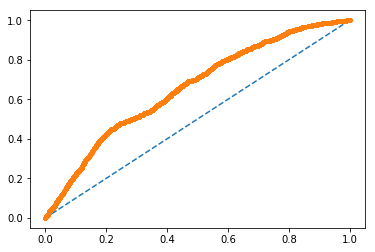

In [108]:
fpr0, tpr0, thresholds0 = metrics.roc_curve(y_test, y_probs)

# plot no skill
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr0, tpr0, marker='.')
# show the plot
pyplot.show()

<a id='inspectfeatures'></a>
# Inspect Features
<a href=#top>Top</a>

In [45]:
x_train.head()

,score_pd,score_payment_assessment,code_sbi_2,color_credit_status
1019429,-5.800,20.0,77.0,G
1039364,-5.510,28.0,14.0,R
515122,-5.596,20.0,47.0,G
586873,-5.624,28.0,46.0,G
640011,-5.712,20.0,56.0,G


In [46]:
x_train.dtypes

score_pd                    float64
score_payment_assessment    float64
code_sbi_2                  float64
color_credit_status          object
dtype: object

In [48]:
x_train.color_credit_status.unique()

array(['G', 'R', 'O'], dtype=object)

In [47]:
x_train.color_credit_status.value_counts()

G    815251
R    232242
O     31460
Name: color_credit_status, dtype: int64

<a id='dummy'></a> 
## Create Dummy Variables
<a href=#top>Top</a>

In [150]:
def one_hot_encode(cat_vars, pd_data = None): 
    import pandas as pd
    for var in cat_vars:
        cat_list='var'+'_'+var
        cat_list = pd.get_dummies(pd_data[var], prefix=var)
        data1=pd_data.join(cat_list)
        pd_data = data1
        
    data_vars=pd_data.columns.values.tolist()
    to_keep=[i for i in data_vars if i not in cat_vars]   
    
    return pd_data[to_keep]


In [72]:
cat_vars=['color_credit_status']

for var in cat_vars:
    cat_list='var'+'_'+var
    cat_list = pd.get_dummies(data_to_model[var], prefix=var)
    data1=data_to_model.join(cat_list)
    data_to_model = data1
    

In [73]:
data_to_model.head()

,score_pd,score_payment_assessment,code_sbi_2,color_credit_status,has_relocated,color_credit_status_G,color_credit_status_O,color_credit_status_R
0,-4.851,28.0,47.0,R,False,0,0,1
1,-5.066,20.0,45.0,G,False,1,0,0
2,-5.658,28.0,55.0,G,False,1,0,0
3,-5.009,20.0,27.0,G,False,1,0,0
4,-5.657,20.0,94.0,G,False,1,0,0


In [74]:
data_vars=data_to_model.columns.values.tolist()
to_keep=[i for i in data_vars if i not in cat_vars]

In [75]:
to_keep

['score_pd',
 'score_payment_assessment',
 'code_sbi_2',
 'has_relocated',
 'color_credit_status_G',
 'color_credit_status_O',
 'color_credit_status_R']

In [76]:
data_final=data_to_model[to_keep]
data_to_model = data_final
data_to_model.columns.values

array(['score_pd', 'score_payment_assessment', 'code_sbi_2',
       'has_relocated', 'color_credit_status_G', 'color_credit_status_O',
       'color_credit_status_R'], dtype=object)

<a id='balancedata'></a>
## Balance Data:

<a href=#top>Top</a>

In [110]:
# Choose desired class breakdown
fraction_majority = 0.60

In [111]:
num_minority = data_df[data_df['has_relocated']==True].shape[0]

num_majority = fraction_majority * num_minority / (1 - fraction_majority)

num_minority, int(num_majority), num_majority, num_majority/(num_majority + num_minority)

(5818, 8726, 8726.999999999998, 0.6)

In [112]:
# Separate majority and minority classes
df_majority = data_df[data_df.has_relocated==False]
df_minority = data_df[data_df.has_relocated==True]

# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=int(num_majority),     # to match minority class
                                 random_state=123) # reproducible results
 
# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
 
# Display new class counts
df_downsampled.has_relocated.value_counts()

False    8726
True     5818
Name: has_relocated, dtype: int64

In [113]:
df_downsampled.has_relocated.value_counts()/df_downsampled.shape[0]

False    0.599972
True     0.400028
Name: has_relocated, dtype: float64

<a id='logistic_rebalance'></a>

# Logistic Regression on Re-balanced data

<a href=#top>Top</a>

In [151]:
feature_cols = ['score_pd', 'score_payment_assessment', 'code_sbi_2', 'color_credit_status']

In [152]:
data_to_model = one_hot_encode(['color_credit_status'], df_downsampled[feature_cols + ['has_relocated']])

features_in_model = data_to_model.columns.tolist()

features_in_model.remove('has_relocated')

x_re_train, x_re_test, y_re_train, y_re_test = train_test_split(data_to_model[features_in_model], 
                                                                data_to_model.has_relocated, 
                                                    test_size=0.25, random_state=0)


In [159]:
logisticRegr = LogisticRegression()

In [160]:
logisticRegr.fit(x_re_train, y_re_train)

/home/mrodriguezlara/graydon/graydon-moving/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [161]:
y_re_pred=logisticRegr.predict(x_re_test)

In [162]:
cnf_matrix = metrics.confusion_matrix(y_re_test, y_re_pred)
cnf_matrix

array([[1758,  401],
       [ 874,  603]])

In [163]:
print('Accuracy of logistic regression classifier on test set: {:.4f}'.format(logisticRegr.score(x_re_test, y_re_test)))

Accuracy of logistic regression classifier on test set: 0.6493


In [165]:
score=metrics.accuracy_score(y_re_test, y_re_pred)

# Get probabilities
y_re_probs = logisticRegr.predict_proba(x_re_test)

# keep probabilities for the positive outcome only
y_re_probs = y_re_probs[:, 1]

auc = metrics.roc_auc_score(y_re_test, y_re_probs)

kappa = metrics.cohen_kappa_score(y_re_test, y_re_pred)
cr=metrics.classification_report(y_re_test, y_re_pred)

In [166]:
score, auc, kappa

(0.6493399339933993, 0.6516289764030403, 0.23438093507951985)

In [167]:
print(cr)

              precision    recall  f1-score   support

       False       0.67      0.81      0.73      2159
        True       0.60      0.41      0.49      1477

   micro avg       0.65      0.65      0.65      3636
   macro avg       0.63      0.61      0.61      3636
weighted avg       0.64      0.65      0.63      3636



<a id='plot'></a>
# Plot

<a href=#top>Top</a>


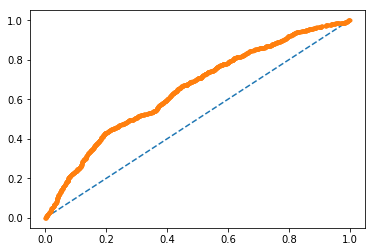

In [168]:
fpr, tpr, thresholds = metrics.roc_curve(y_re_test, y_re_probs)
# plot no skill
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='.')
# show the plot
pyplot.show()

## Notes:

https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/

<a id='bottom'></a>

<a href=#top>Top</a>

# End